# PLOT Sea Ice  and Sea Ice loss for a MAP and over TIME from ISIS
## Used for: 
    - hom_P-2Pr

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import gridspec
fs=20 #fontsize for labels, legend, ...
font={'family' : 'serif', 'size' : fs} #define font for legend
plt.rc('font', **font)
import cmocean
from mpl_toolkits.basemap import Basemap
# import via conda install basemap (for some reason pip doesnt work)
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
climber_path='/home/peter/PIK/climber/' #/home/peter/PIK/climber/
data_grid=xr.open_dataset(
    climber_path+'data_preparation/snapshots_potsdam2.055623.01.01.dta.nc', 
    decode_times=False)

In [6]:
ref=[]
refname="hom_REF"
p=[]
runname="hom_P-SSP5_opt1WB"
runname="hom_P-2Pr"
long_years=np.arange(54863, 55104, step=10)
years=long_years-54983+2010
print(years)
for y in long_years:
    ref.append(xr.open_dataset(
        climber_path+"/cluster_results/data_Mai8files/"+"c3beta_anthrHeat_"+refname+'/snaps/'+
        "snapshots_isis.0"+str(y)+".01.01.dta.nc", decode_times=False))
    p.append(xr.open_dataset(
        climber_path+"/cluster_results/data_Mai8files/"+"c3beta_anthrHeat_"+runname+'/snaps/'+
        "snapshots_isis.0"+str(y)+".01.01.dta.nc", decode_times=False))
X,Y = np.meshgrid(np.insert(ref[0].xu_i,0,0), np.insert(ref[0].yu_j, 0, -90))
#print(X,Y)

[1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030
 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130]


In [4]:
def total_sum(x,lats=ref[0].yt_j, lon=ref[0].xt_i):
    '''x should have dimensions: lat,lon'''
    weights=np.cos(lats*np.pi/180)
    irrelevant,real_weights=np.meshgrid(lon, weights)
    nans=np.where(np.isnan(x))
    x=remove_nan(x, value=0.0)
    for i in range(0,len(nans[0])):
        real_weights[nans[0], nans[1]]=0.0
    dlat=lats[1]-lats[0]; dlon=lon[1]-lon[0]
    z=real_weights*x* dlat*np.pi/180 *dlon*(2*np.pi)/360 *6371000**2
    return np.sum(z)
def area_mean_lon(x, lats=ref[0].yt_j, lon=ref[0].xt_i):
    '''x should have dimensions: lat,lon'''
    weights=np.cos(lats*np.pi/180)
    irrelevant,real_weights=np.meshgrid(lon, weights)
    nans=np.where(np.isnan(x))
    x=remove_nan(x, value=0.0)
    for i in range(0,len(nans[0])):
        real_weights[nans[0], nans[1]]=0.0
    z=real_weights*x
    return np.sum(z)/np.sum(real_weights)
def get_time(y):
    return (y+54783-1-1810)*360-0.5
def get_year(t):
    return (t+0.5)/360 +1810+1-54783
    #return (t+54783-1-1810)*360-0.5

In [5]:
def change_to_Atl(x, grid=ref[0]):
    new_x=np.copy(x)
    #print(np.shape(new_x))
    switch=np.where(grid.xt_i>180)[0][0]
    for i in range(0,len(grid.xt_i)):
        if grid.xt_i[i]>180:
            new_x[:,i-switch]=x[:,i]
            #print(i-switch)
        else:
            new_x[:,i+switch]=x[:,i]
            #print(i+switch)
    return new_x
#frlnd_atl=change_to_Atl(data_grid.frlnd[0])
X_atl=X-180
Y_atl=Y

In [6]:
def remove_nan(x, value=0.0):
    for i in range(0,len(x[:,0])):
        for j in range(0,len(x[0,:])):
            if np.isnan(x[i,j]):
                x[i,j]=value
#            if np.isnan(ref_[i,j]):
#                ref_[i,j]=0.0
#            if (np.isnan(p_[i,j]) and not np.isnan(ref_[i,j])) or (np.isnan(ref_[i,j]) and not np.isnan(p_[i,j])):
#                print(i,j)#ax.plot(x, p_)
#    return p_, ref_
    return x

In [7]:
P=[]
for y in years:
    if y>2010:
        P.append(1.02**(y-2010)*np.loadtxt(
            "../data_preparation/PMIP/P_hum/txt_file_each_yearJul13_11-20/P_hum_year2010.dat"))
    else:
        P.append(np.loadtxt(
            "../data_preparation/PMIP/P_hum/txt_file_each_yearJul13_11-20/P_hum_year"+str(y)+".dat"))
    

In [8]:
ref_seaIce=[]
p_seaIce=[]
for i in ref:
    ref_seaIce.append(remove_nan(i.con_g.mean(dim='Time')[0]))
for i in p:
    p_seaIce.append(remove_nan(i.con_g.mean(dim='Time')[0]))

In [9]:
def runandplot(y, p_seaIce, ref_seaIce, gyre):
    ind=np.where(years==y)[0][0]
    fig=plt.figure(figsize=(16,9))
    ax1=fig.add_subplot(111)
    ax1.set_title(r"${\rm Sea \ Ice \ Fraction}$ in "+str(y)+" (reference run)")

    if gyre==True:     
        m = Basemap(projection='cyl',llcrnrlat=data_grid.yu_j[15],urcrnrlat=data_grid.yu_j[-1],\
                        llcrnrlon=180-data_grid.xu_i[12],urcrnrlon=data_grid.xu_i[2],resolution='c')
        m.drawcoastlines()
        m.fillcontinents(color='gray', lake_color=plt.cm.get_cmap('Blues_r')(0), alpha=0.7)
        plot=ax1.pcolormesh(X_atl, Y_atl, change_to_Atl(ref_seaIce[ind]), vmin=0, vmax=1, cmap='Blues_r', alpha=0.8)
    else:
        plot=ax1.pcolormesh(X_atl,Y_atl,change_to_Atl(ref_seaIce[ind]), vmin=0, vmax=1, cmap='Blues_r', alpha=0.8)
        m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
                llcrnrlon=-180,urcrnrlon=180,resolution='c')
        m.drawcoastlines()
        m.fillcontinents(color='gray', lake_color=plt.cm.get_cmap('Blues_r')(0), alpha=0.7)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cb=plt.colorbar(plot, cax=cax, label=r'${\rm \ sea \ ice \ fraction}$')
    if gyre==True:
        ax1.set_xticks([X_atl[0,:][len(X_atl[0,:])/4],X_atl[0,:][len(X_atl[0,:])/2]])
        ax1.set_yticks([Y_atl[:,0][len(Y_atl[:,0])/4*3], Y_atl[:,0][-1]])
    else:
        ax1.set_xticks([X_atl[0,:][0],X_atl[0,:][len(X_atl[0,:])/4],X_atl[0,:][len(X_atl[0,:])/2],X_atl[0,:][len(X_atl[0,:])/4*3], X_atl[0,:][-1]])
        ax1.set_yticks([Y_atl[:,0][0],Y_atl[:,0][len(Y_atl[:,0])/4],Y_atl[:,0][len(Y_atl[:,0])/2],Y_atl[:,0][len(Y_atl[:,0])/4*3], Y_atl[:,0][-1]])
    #ax1.set_yticklabels([str(int(l.get_position()[1])) for l in ax1.get_yticklabels()], fontdict={"fontsize":16})
    #ax1.set_xticklabels([str(int(l.get_position()[0])) for l in ax1.get_xticklabels()], fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel("  ")
    fig.tight_layout()
    plot_name="seaice_"+str(y)
    if gyre==True: plot_name= plot_name+"_fluct"
    plt.savefig(plot_name+".eps", format='eps', bbox_inches='tight')


    fig=plt.figure(figsize=(16,9))
    ax2=fig.add_subplot(111)
    diff_ice=p_seaIce[ind]-ref_seaIce[ind]
    ax2.set_title(r"$\Delta \ {\rm Sea \ Ice \ Fraction}$ in "+str(y)+r" $\overline{P_{\rm hum} \cdot {\rm Fr}_{\rm land}}="+
                 '%.3f' % area_mean_lon(data_grid.frlnd[0]*P[np.where(years==y)[0][0]], lats=data_grid.yt_j, lon=data_grid.xt_i)+r"\, {\rm W/m^2} \rightarrow "
                +r"\overline{\Delta \alpha_S}=$"+ '%.4f' % area_mean_lon(diff_ice), y=1.02)
    if gyre==True:     
        m = Basemap(projection='cyl',llcrnrlat=data_grid.yu_j[15],urcrnrlat=data_grid.yu_j[-1],\
                        llcrnrlon=180-data_grid.xu_i[12],urcrnrlon=data_grid.xu_i[2],resolution='c')
        m.drawcoastlines()
        m.fillcontinents(color='gray', lake_color='white', alpha=0.7)
        plot=ax2.pcolormesh(X_atl, Y_atl, change_to_Atl(diff_ice), vmin=-0.05, vmax=0.05, cmap='bwr_r')
    else:
        plot=ax2.pcolormesh(X_atl,Y_atl,change_to_Atl(diff_ice), vmin=-0.05, vmax=0.05, cmap='bwr_r')
        m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
        m.drawcoastlines()
        m.fillcontinents(color='gray', lake_color='white', alpha=0.3)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cb=plt.colorbar(plot, cax=cax, label=r'$\Delta {\rm \ sea \ ice \ fraction}$')
    if gyre==True:
        ax2.set_xticks([X_atl[0,:][len(X_atl[0,:])/4],X_atl[0,:][len(X_atl[0,:])/2]])
        ax2.set_yticks([Y_atl[:,0][len(Y_atl[:,0])/4*3], Y_atl[:,0][-1]])
    else:
        ax2.set_xticks([X_atl[0,:][0],X_atl[0,:][len(X_atl[0,:])/4],X_atl[0,:][len(X_atl[0,:])/2],X_atl[0,:][len(X_atl[0,:])/4*3], X_atl[0,:][-1]])
        ax2.set_yticks([Y_atl[:,0][0],Y_atl[:,0][len(Y_atl[:,0])/4],Y_atl[:,0][len(Y_atl[:,0])/2],Y_atl[:,0][len(Y_atl[:,0])/4*3], Y_atl[:,0][-1]])
    ax2.set_xlabel("  ")
    ax2.tick_params(axis='both', which='major', labelsize=16)

    fig.tight_layout()
    plot_name="d_seaice_"+str(y)
    if gyre==True: plot_name= plot_name+"_fluct"
    plt.savefig(plot_name+".eps", format='eps', bbox_inches='tight')
    return

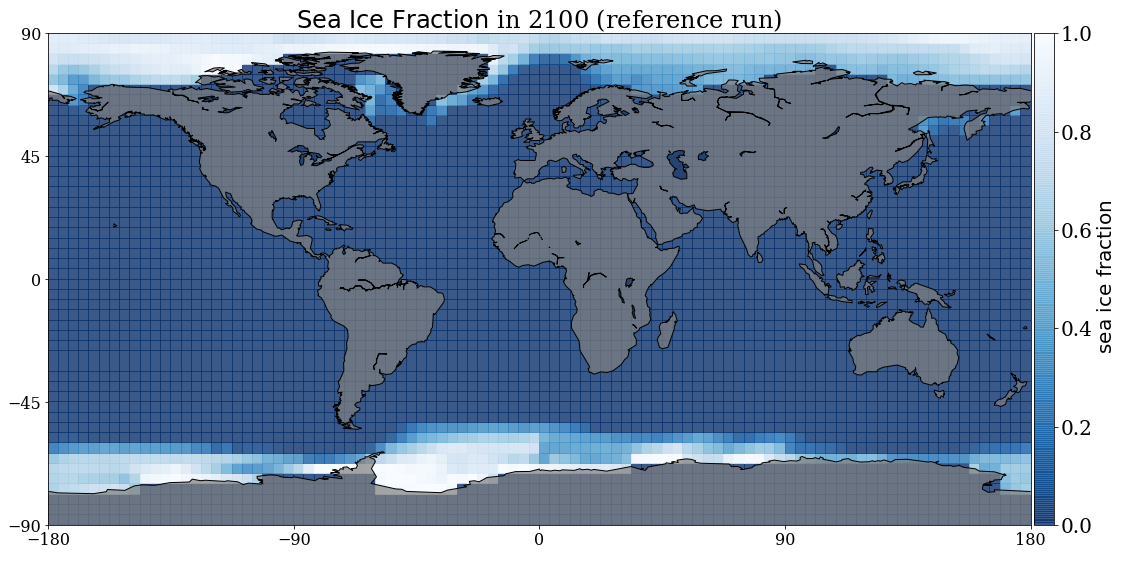

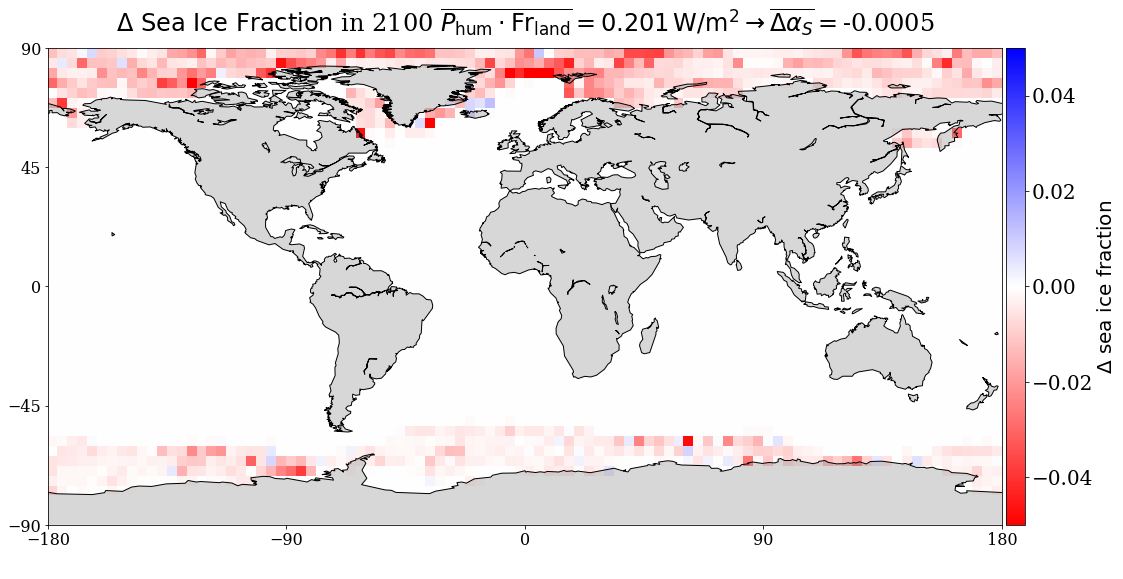

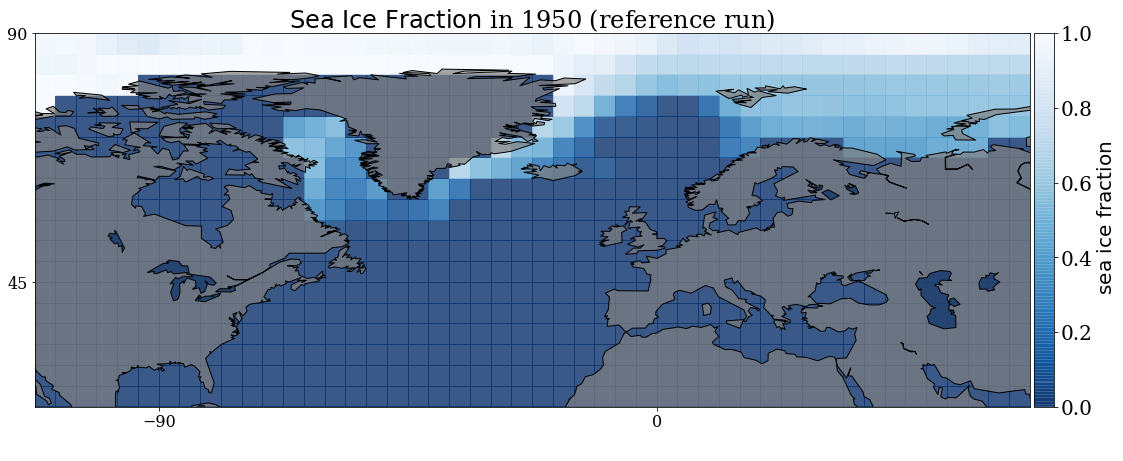

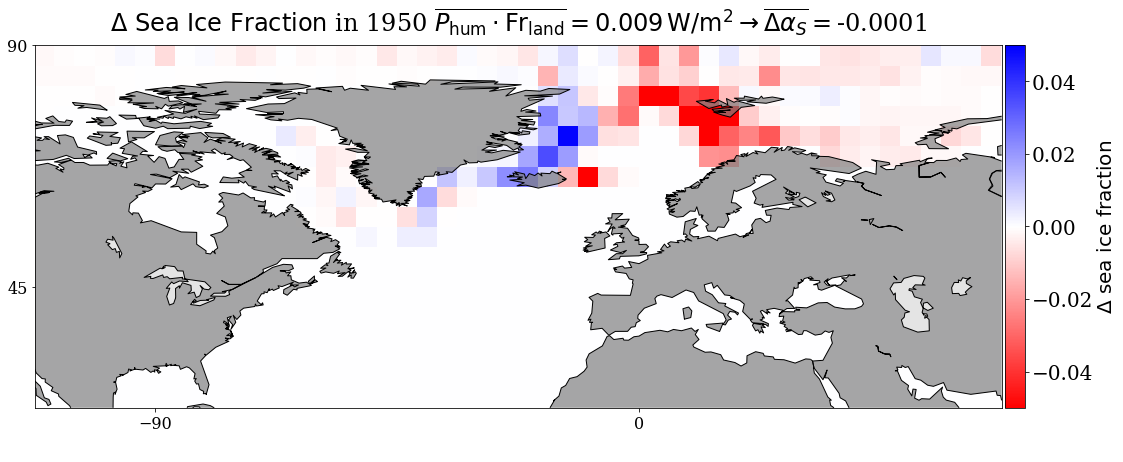

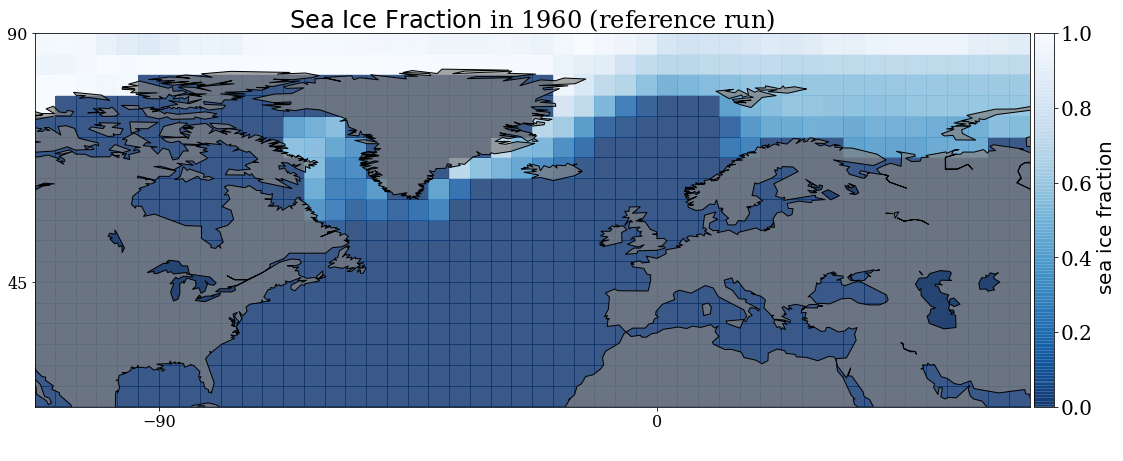

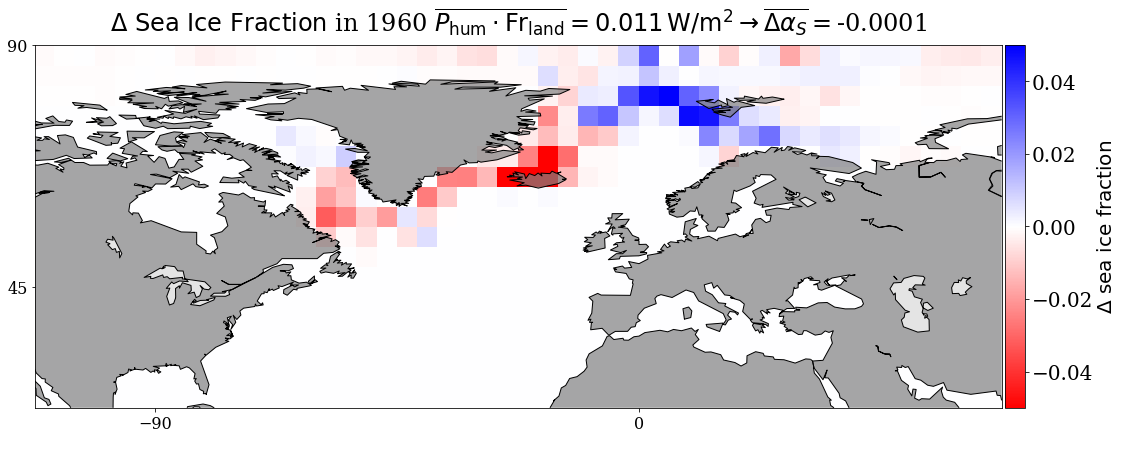

In [10]:
y=2100
gyre=False
runandplot(y, p_seaIce, ref_seaIce, gyre)
gyre=True
y=1950
runandplot(y, p_seaIce, ref_seaIce, gyre)
y=1960
runandplot(y, p_seaIce, ref_seaIce, gyre)

# PLOT Sea Ice Extent over time

In [11]:
tot_sum=[]
tot_sum_p=[]
for i in range(0,len(years)):
    tot_sum.append(total_sum(ref[i].con_g.mean(dim='Time')[0]))
    tot_sum_p.append(total_sum(p[i].con_g.mean(dim='Time')[0]))

In [12]:
fig=plt.figure(figsize=(8,4))
ax1=fig.add_subplot(111)
ax1.set_title(r"Sea Ice Extent $[{\rm m^2}]$")
ax1.set_xlabel("time")
ax1.plot(years, tot_sum, label="Reference run", lw=2)
ax1.plot(years, tot_sum_p, label=r"$P_{\rm hum}$-run"+"\n"+"(with $2\%$-growth per year after 2010)", lw=2)
ax1.grid()
ax1.legend()
plt.close()

fig=plt.figure(figsize=(8,4))
ax2=fig.add_subplot(111)
ax2.set_title(r"$\Delta {\rm \ Sea\ Ice\ Extent\ }[{\rm m^2}]$")
totaler_Eisverlust=np.array(tot_sum_p)-np.array(tot_sum)
ax2.plot(years, totaler_Eisverlust, lw=3)
ax2.grid()
plt.close()

In [13]:
(totaler_Eisverlust*1e-6)[-1]

-410574.56581854296

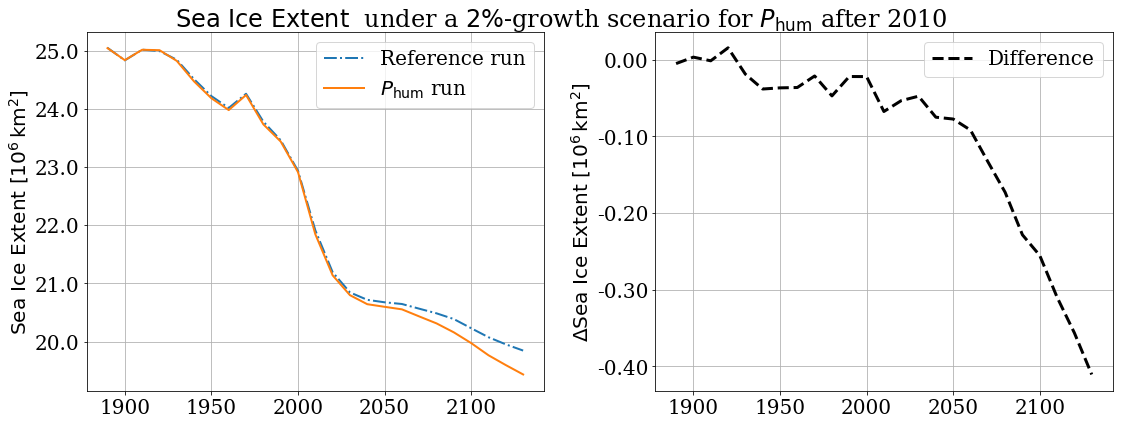

In [14]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(121)
#ax1.set_title("")
#ax1.plot([],[], ' ',label="Sea Ice Extent $[m^2]$")
ax1.set_ylabel(r"${\rm Sea\ Ice\ Extent\ }[10^{6}\, {\rm km^2}]$")
ax1.plot(years, np.array(tot_sum)*1e-6*1e-6,'-.', label="Reference run", lw=2)
ax1.plot(years, np.array(tot_sum_p)*1e-6*1e-6, label=r"$P_{\rm hum}$ run", lw=2)
ax1.set_yticklabels(['%.1f' % l for l in ax1.get_yticks()])
ax1.grid()
ax1.legend()

ax2=fig.add_subplot(122)
totaler_Eisverlust=np.array(tot_sum_p)-np.array(tot_sum)
ax2.plot(years, totaler_Eisverlust*1e-6*1e-6,'--', lw=3, color='black', label='Difference')
ax2.set_ylabel(r"$\Delta {\rm Sea\ Ice\ Extent\ }[10^{6}\, {\rm km^2}]$")
ax2.grid()
ax2.set_yticklabels(['%.2f' % l for l in ax2.get_yticks()])
ax2.legend()

fig.suptitle(r"${\rm Sea\ Ice\ Extent\ }$ under a $2\%$-growth scenario for $P_{\rm hum}$ after 2010", y=1.0)
fig.tight_layout()
plt.savefig("tot_seaIce_extent_"+runname+"_SSP.eps", format='eps', bbox_inches='tight')

In [15]:
(totaler_Eisverlust*1e-6)[np.where(years==2100)]

array([-255426.67087346])

In [16]:
(totaler_Eisverlust*1e-6)[-1]/(4*np.pi*6371**2)   * 0.6

-0.00048296784633667869

# FUTURE REVERSIBILITY

In [25]:
ref=[]
refname="hom_REF"
p=[]
runname="hom_P-2Pr_rev"
long_years=np.arange(54863, 52973+2250+1, step=40)
years=long_years-54983+2010
print(years)
for y in long_years:
    ref.append(xr.open_dataset(
        climber_path+"/cluster_results/data_Mai8files/"+"c3beta_anthrHeat_"+refname+'/snaps/'+
        "snapshots_isis.0"+str(y)+".01.01.dta.nc", decode_times=False))
    p.append(xr.open_dataset(
        climber_path+"/cluster_results/data_Mai8files/"+"c3beta_anthrHeat_"+runname+'/snaps/'+
        "snapshots_isis.0"+str(y)+".01.01.dta.nc", decode_times=False))
#print(X,Y)

[1890 1930 1970 2010 2050 2090 2130 2170 2210 2250]


In [26]:
P=[]
for y in years:
    if y>2010:
        P.append(1.02**(y-2010)*np.loadtxt(
            "../data_preparation/PMIP/P_hum/txt_file_each_yearJul13_11-20/P_hum_year2010.dat"))
    else:
        P.append(np.loadtxt(
            "../data_preparation/PMIP/P_hum/txt_file_each_yearJul13_11-20/P_hum_year"+str(y)+".dat"))
    

In [27]:
ref_seaIce=[]
p_seaIce=[]
for i in ref:
    ref_seaIce.append(remove_nan(i.con_g.mean(dim='Time')[0]))
for i in p:
    p_seaIce.append(remove_nan(i.con_g.mean(dim='Time')[0]))

In [28]:
years

array([1890, 1930, 1970, 2010, 2050, 2090, 2130, 2170, 2210, 2250])

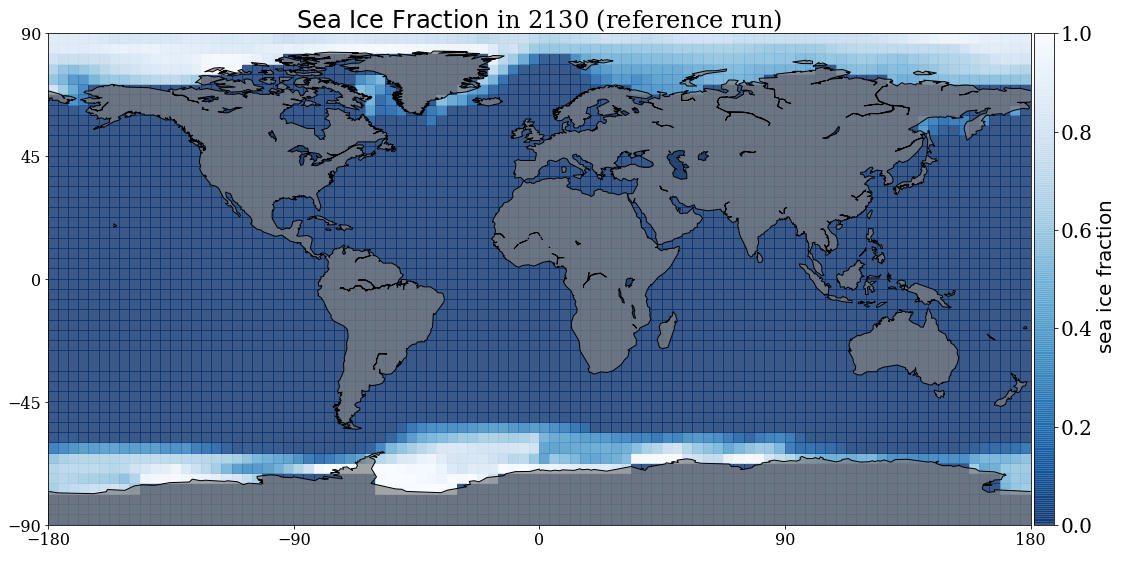

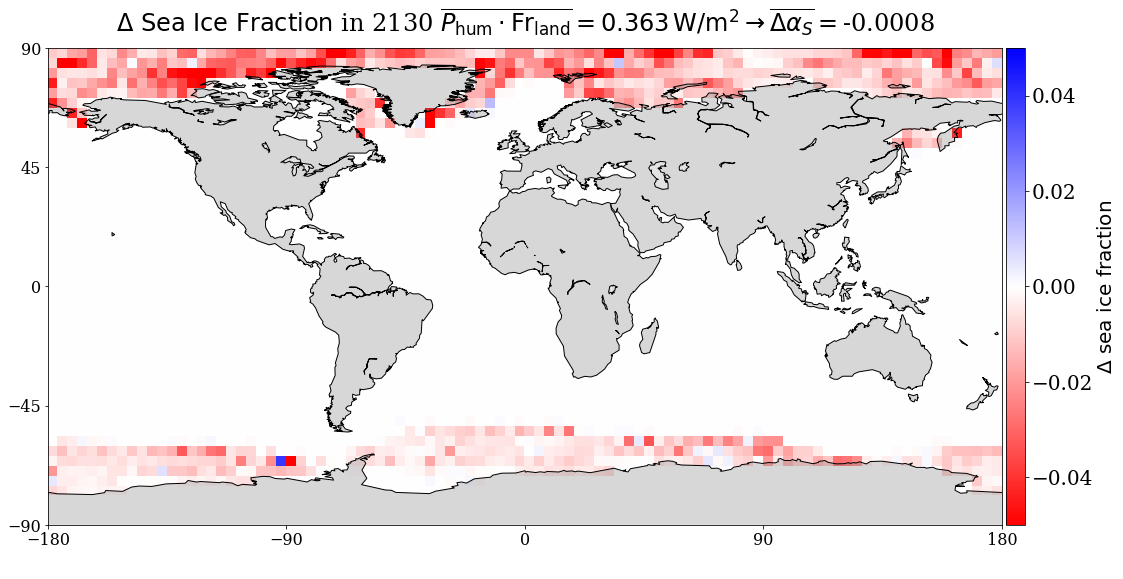

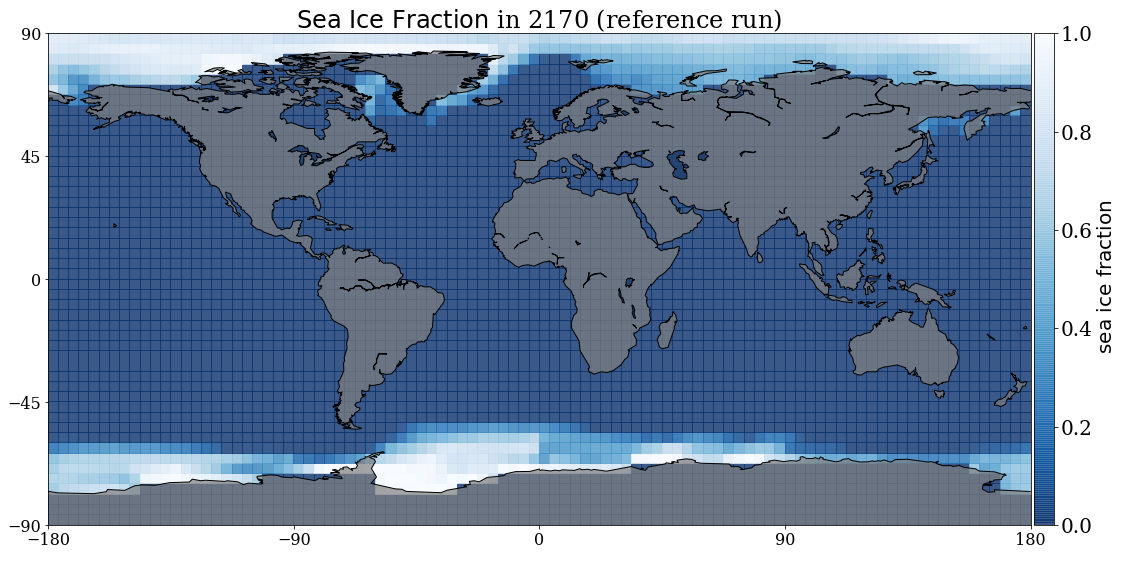

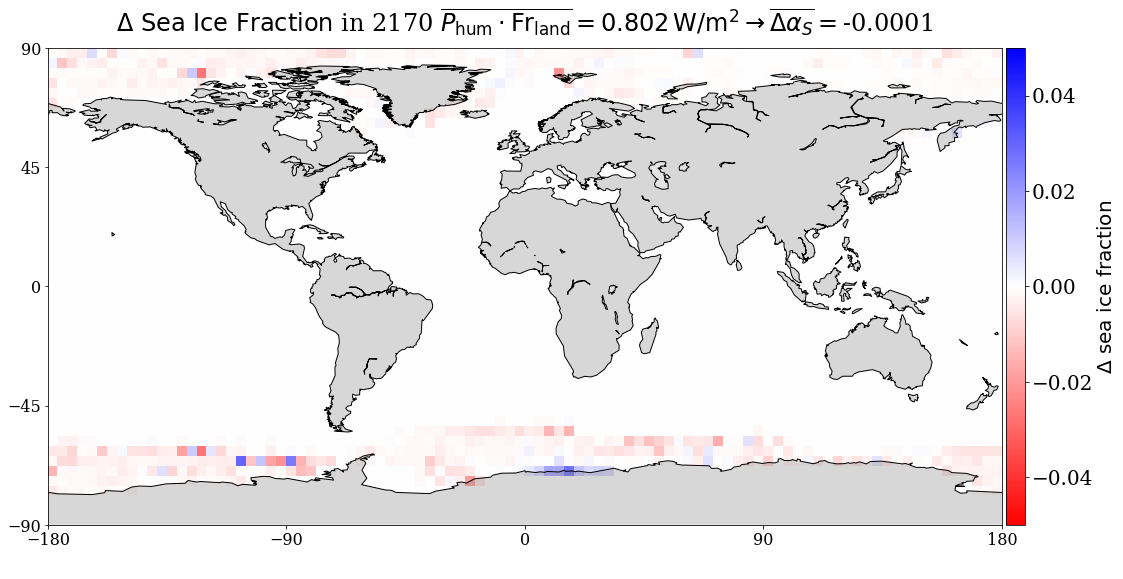

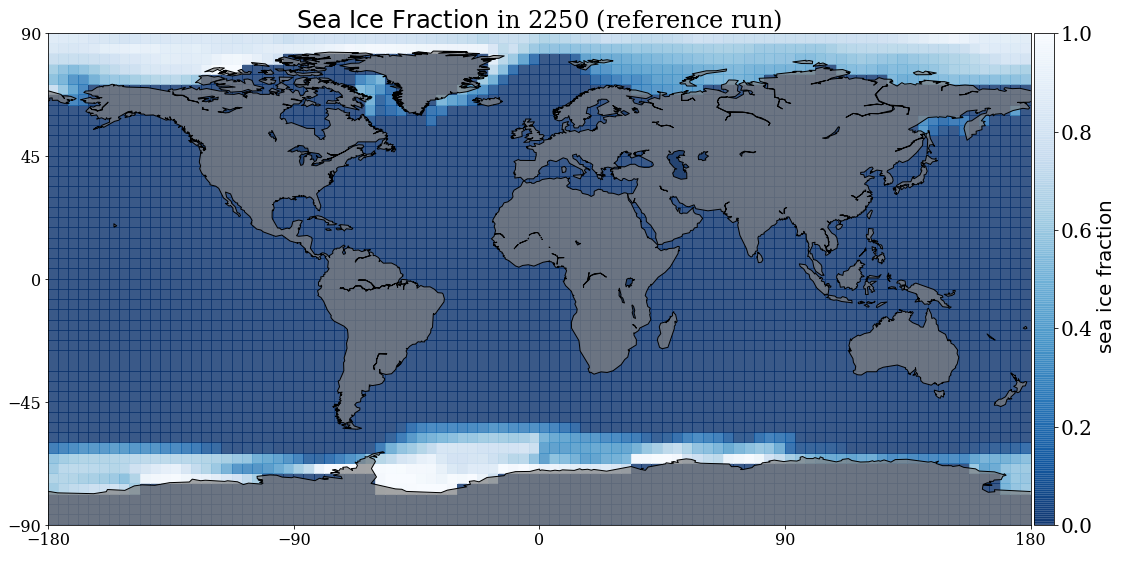

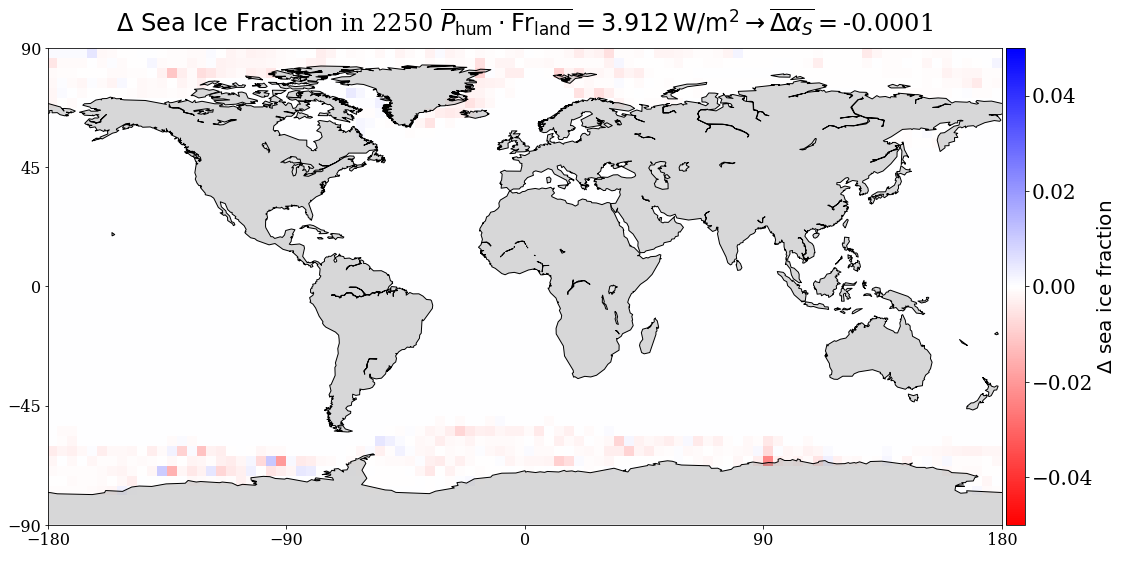

In [29]:
y=2130
gyre=False
runandplot(y, p_seaIce, ref_seaIce, gyre)

y=2170
gyre=False
runandplot(y, p_seaIce, ref_seaIce, gyre)

y=2250
gyre=False
runandplot(y, p_seaIce, ref_seaIce, gyre)
